In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=10, processes=True)
client = Client(cluster)  # memory_limit='16GB', 

import xarray as xr
from dask.diagnostics import ProgressBar

In [2]:
client

Client Scheduler: tcp://127.0.0.1:44513 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 40 Memory: 203.20 GB


In [3]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/bin/python3


In [4]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')
static

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 53, time: 31)
Coordinates:
  * longitude  (longitude) float32 7.0 7.25 7.5 7.75 ... 19.25 19.5 19.75 20.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 2000-01-01T23:00:00 ... 2000-01-31T23:00:00
Data variables:
    slt        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    slor       (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.6
    history:      Thu May 30 01:39:36 2019: cdo dayavg /home/srvx11/lehre/use...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

In [5]:
era5 = xr.open_mfdataset('../data/danube/*1981-2017*.nc')

import datetime as dt
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [6]:
# sanitize the coordinates; cdo daysum assigned the coordinate 23 UTC for all days
era5 = shift_time(era5, -dt.timedelta(hours=23))

In [7]:
glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))

In [8]:
glofas_rerun = xr.open_dataset('../data/glofas-freruns/2013051800/glofas2.3_era5wb_reforecast_dis_bigchannels_1000km2_20130518_0.nc')
glofas_rerun = glofas_rerun.rename({'lat': 'latitude', 'lon': 'longitude'})
glofas_rerun = shift_time(glofas_rerun, -dt.timedelta(days=1))

### Interpolation step

In [9]:
era5 = era5.interp(latitude=glofas.latitude, longitude=glofas.longitude)

### Feature engineering

In [10]:
era5 = era5.isel(time=slice(0,1000))
glofas = glofas.isel(time=slice(0,1000))

In [11]:
krems = dict(latitude=48.403, longitude=15.615)

surrounding = dict(latitude=slice(krems['latitude']+1, 
                                  krems['latitude']-1),
                   longitude=slice(krems['longitude']-1, 
                                  krems['longitude']+1))

y = glofas.interp(krems)
X = era5[['cp', 'lsp']]

X = X.sel(surrounding).sum(['latitude', 'longitude'])


In [12]:
if False:
    xdf = X.to_dataframe()
    ydf = y.drop(['latitude', 'longitude']).to_dataframe()

    xdf.head()

    ydf.plot(y='dis', figsize=(15,5))
    fig, ax = plt.subplots()
    xdf.plot(y=['lsp', 'cp'], ax=ax, figsize=(15,5))
    plt.close()
    
    xdf.cumsum().plot(y=['lsp', 'cp'], figsize=(15,5))
    
    merge = pd.concat([xdf, ydf], axis=1)
    merge.head()

In [13]:
#sns.jointplot(x='cp', y='dis', data=merge, kind='hex')

In [14]:
#sns.jointplot(x='lsp', y='dis', data=merge, kind='hex')

In [15]:
def mask_dataframe(df, limit_per_variable: dict):
    for var, (lowlim, uplim) in limit_per_variable.items():
        df = df[var > lowlim]
        df = df[var < uplim]
    return df

def normalize(series):
    return series #(series-series.mean())/series.std()

def normalize_df(df):
    dic = []
    for var, d in xdf.items():
        dic.append( normalize(d) )
    return #pd.concat(dic)

## daily change in discharge 
As discharge itself has a large memory component (high autocorrelation, dependence on previous values), we can also look on the changes in discharge through time.

In [16]:
# select data of interest
y = glofas.interp(krems)
X = era5[['cp', 'lsp']]

# prepare predictor
X = X.sel(surrounding).sum(['latitude', 'longitude'])

y = y.where(y>0)

In [17]:
# normalize
X = (X - X.mean('time'))/X.std('time')
y = (y - y.mean('time'))/y.std('time')

In [18]:
if False: # debug
    for t in range(len(X.time)):
        print(X.time.values[t], y.time.values[t])

## Is there a relationship 

In [19]:
#sns.jointplot(x='cp', y='dis', data=merge, kind='hex')

In [20]:
#sns.jointplot(x='lsp', y='dis', data=merge, kind='hex')

In [21]:
#from sklearn_xarray import wrap
#from dask_ml.xgboost import XGBRegressor
from dask_ml.linear_model import LinearRegression
# LogisticRegression

In [22]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [23]:
shifts = range(1,11)

Xs = add_shifted_predictors(X, shifts)


In [24]:
Xar = Xs.to_array(dim='features') #
yar = y.to_array()

# singleton dimension has to have the same name like in X
# so we set it to 'features' too
yar = yar.rename({'variable': 'features'})  

# it confuses the concat if one has latitude but the other not
yar = yar.drop(['latitude', 'longitude'])  
    
    

## concat
- allows us to synchronize times and 
- get rid of nan entries with dropna()

In [25]:
Xy = xr.concat([Xar, yar], dim='features')  

Xyt = Xy.dropna('time')  # drop them as we cannot train on nan values

In [26]:
Xyt

<xarray.DataArray (features: 23, time: 990)>
dask.array<shape=(23, 990), dtype=float64, chunksize=(1, 990)>
Coordinates:
  * time      (time) datetime64[ns] 1981-01-11 1981-01-12 ... 1983-09-27
  * features  (features) object 'cp' 'lsp' 'cp-1' ... 'lsp-9' 'lsp-10' 'dis'

In [27]:
predictand = 'dis'
predictors = [v for v in X.data_vars if predictand not in v]
predictors

Xda = Xyt.loc[predictors]
yda = Xyt.loc[predictand]

In [28]:
time = yda.time
Xda = Xda.chunk(dict(time=-1, features=-1)).data.T
yda = yda.data.squeeze()

In [29]:
Xda

dask.array<transpose, shape=(990, 22), dtype=float64, chunksize=(990, 22)>

In [30]:
yda

dask.array<getitem, shape=(990,), dtype=float64, chunksize=(990,)>

In [31]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression


In [77]:
model_kws = dict(n_jobs=-1, max_iter=1000, verbose=True)

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', LinearRegression(**model_kws)),],
                verbose=True)

In [78]:
pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LinearRegression(C=1.0, class_weight=None, dual=False,
                                  fit_intercept=True, intercept_scaling=1.0,
                                  max_iter=1000, multi_class='ovr', n_jobs=-1,
                                  penalty='l2', random_state=None,
                                  solver='admm', solver_kwargs=None, tol=0.0001,
                                  verbose=True, warm_start=False))],
         verbose=True)

In [79]:
Xda = Xda.persist()

with ProgressBar():
    pipe.fit(Xda, yda)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.0s


# Test it on the same data

In [80]:
with ProgressBar():
    ytest = pipe.predict(Xda)

In [81]:
ytest.shape

(990,)

In [82]:
xr.DataArray(ytest, dims=('time'), coords={'time': time})

<xarray.DataArray 'sum-aggregate-a0175cc78adb5eb0474c8f0a20a31cd7' (time: 990)>
dask.array<shape=(990,), dtype=float64, chunksize=(990,)>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-11 1981-01-12 ... 1983-09-27

In [83]:
def add_time(vector, time, name=None):
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [84]:
ytest = add_time(ytest, time, name='dis-forecast')

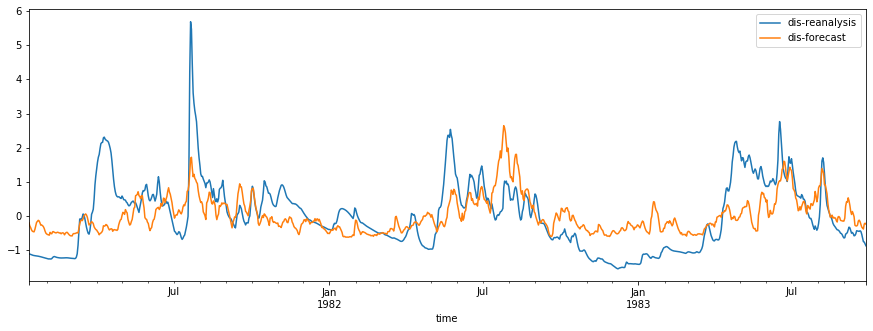

In [85]:
fig, ax = plt.subplots(figsize=(15,5))
Xyt.loc[predictand].to_pandas().plot(ax=ax, label='dis-reanalysis')
ytest.to_pandas().plot(ax=ax, label='dis-forecast')
plt.legend()